## Importacion de las librerias necesarias

In [1]:
# # Instalacion de otras librerias
# !pip install colour-science
# !pip install xgboost
# !pip install scikeras
# !pip install yellowbrick

In [2]:
# Manejo de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils

# Ploting
import matplotlib.pyplot as plt
import colour

# Algoritmos de ML
import tensorflow as tf
from tensorflow import keras
import scikeras

# Implementacion de tensorboard
# Load the TensorBoard notebook extension
# %load_ext tensorboard
import datetime
import optuna

## Lectura del CSV

In [3]:
# df = pd.read_csv('/content/drive/MyDrive/DataSets/Practicas Profesionales/rgb.csv')
# df_xyz = pd.read_csv('/content/drive/MyDrive/DataSets/Practicas Profesionales/xyz.csv')
# df = df.merge(df_xyz,how='outer')
# df.to_csv('/content/drive/MyDrive/DataSets/Practicas Profesionales/df_rgb_xyz.csv')
# df.head()

In [4]:
df = pd.read_csv('df_rgb_xyz.csv').drop('Unnamed: 0',axis=1)
df['R'] = df['R'] / 100
df['DEE'] = df['DEE'] / 80
df.head()

,R,DEE,Remb,r,g,b,x,y,z
0,0.101691,0.891269,0.5481,0.607739,0.607748,0.610636,0.312052,0.327911,0.360038
1,0.249168,0.539952,0.3979,0.614463,0.662313,0.545797,0.326839,0.373410,0.299751
2,0.914374,0.211320,0.6341,0.643678,0.632023,0.563976,0.331315,0.354632,0.314053
3,0.859463,0.568773,0.8010,0.667089,0.649641,0.526636,0.344984,0.374364,0.280652
4,0.311980,0.182830,0.3469,0.752189,0.582688,0.540596,0.369491,0.343779,0.286731


Parametros esperados de salida

---
* **R:** Radio de Nanoparticula (Dimensiones: nm, Rango: [5, 100])
* **DEE:** Distancia entre Nanoparticulas (Dimensiones: nm, Rango: [5, 80])
* **Remb:** Radio de incrustado (Dimensiones: porcentual, Rango: [0.3, 1])

Parametros esperados de entrada

---
* **r:** Rojo del Espacio de color sRGB (valor de 0 a 1)
* **g:** Verde del Espacio de color sRGB (valor de 0 a 1)
* **b:** Azul del espacio de color sRGB (valor de 0 a 1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24635 entries, 0 to 24634
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R       24635 non-null  float64
 1   DEE     24635 non-null  float64
 2   Remb    24635 non-null  float64
 3   r       24635 non-null  float64
 4   g       24635 non-null  float64
 5   b       24635 non-null  float64
 6   x       24635 non-null  float64
 7   y       24635 non-null  float64
 8   z       24635 non-null  float64
dtypes: float64(9)
memory usage: 1.7 MB


Se determina la precencia de datos faltantes (NaN), lo cual resulta negativo para este caso

## Identificacion y tratado de valores atipicos

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,24635.0,0.565423,0.284399,0.050000,0.345113,0.560209,0.805104,1.000000
DEE,24635.0,0.474598,0.277197,0.062500,0.233058,0.481660,0.674836,1.000000
Remb,24635.0,0.657977,0.188672,0.300000,0.519609,0.690612,0.775595,1.000000
r,24635.0,0.627914,0.080999,-0.181064,0.574962,0.630622,0.685156,0.880922
g,24635.0,0.601236,0.049293,0.363591,0.575145,0.607490,0.629795,0.740896
b,24635.0,0.595498,0.063144,0.280018,0.565935,0.606192,0.632683,0.756195
x,24635.0,0.321553,0.030290,0.204156,0.300711,0.321979,0.343659,0.438084
y,24635.0,0.330612,0.036470,0.221430,0.301435,0.328984,0.351444,0.464530
z,24635.0,0.347835,0.058343,0.127415,0.314741,0.352387,0.383018,0.533591


Aparentenemnte se encontro un detalle en la columna `r`, el valor minimo no entra dentro del rango especificado anteriormente

Numero de outlayers: 2, Los cuales son: [-0.07122901 -0.18106433]


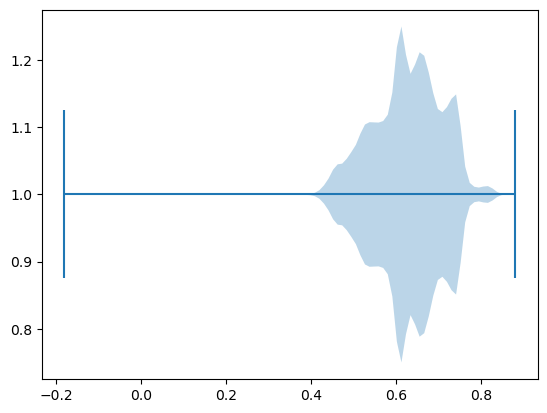

In [7]:
plt.violinplot(df.r,vert=False)
outlayers = df['r'] < 0
outlayers = df[outlayers]
print(f'Numero de outlayers: {outlayers.shape[0]}, Los cuales son: {outlayers["r"].unique()}')

Se corrobora lo anteriormente observado con un diagrama de violin (KDE) y en efecto se cuenta con un valor que sobrepasa el minimo establecido, por lo cual se procede a sustraer la fila donde se encuentra el outlayer.

,count,mean,std,min,25%,50%,75%,max
R,24633.0,0.565397,0.284395,0.050000,0.345107,0.560076,0.805031,1.000000
DEE,24633.0,0.474586,0.277204,0.062500,0.233053,0.481493,0.674823,1.000000
Remb,24633.0,0.657976,0.188673,0.300000,0.519618,0.690612,0.775590,1.000000
r,24633.0,0.627975,0.080715,0.237164,0.575010,0.630646,0.685163,0.880922
g,24633.0,0.601234,0.049294,0.363591,0.575145,0.607489,0.629795,0.740896
b,24633.0,0.595487,0.063135,0.280018,0.565934,0.606191,0.632676,0.756195
x,24633.0,0.321563,0.030274,0.238820,0.300717,0.321979,0.343663,0.438084
y,24633.0,0.330615,0.036469,0.221430,0.301439,0.328984,0.351448,0.464530
z,24633.0,0.347822,0.058328,0.127415,0.314735,0.352387,0.382998,0.533591


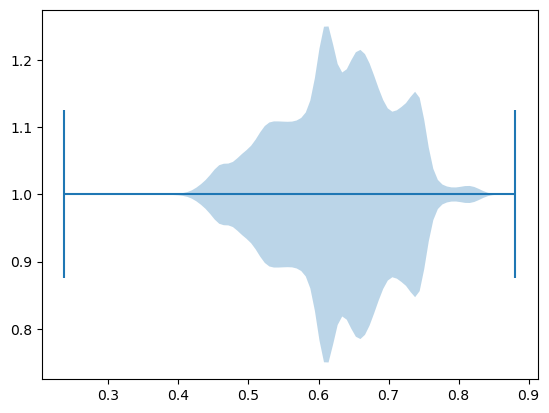

In [8]:
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
plt.violinplot(df.r,vert=False)
df.describe().T

## Creacion de nuevas dataframes con su respectiva variable objetivo

In [9]:
df_3 = df.drop(['x','y','z'],axis=1)
df_3.head()

,R,DEE,Remb,r,g,b
0,0.101691,0.891269,0.5481,0.607739,0.607748,0.610636
1,0.249168,0.539952,0.3979,0.614463,0.662313,0.545797
2,0.914374,0.211320,0.6341,0.643678,0.632023,0.563976
3,0.859463,0.568773,0.8010,0.667089,0.649641,0.526636
4,0.311980,0.182830,0.3469,0.752189,0.582688,0.540596


In [10]:
df_R = df.drop(['DEE','Remb','x','y','z'],axis=1)
df_R.head()

,R,r,g,b
0,0.101691,0.607739,0.607748,0.610636
1,0.249168,0.614463,0.662313,0.545797
2,0.914374,0.643678,0.632023,0.563976
3,0.859463,0.667089,0.649641,0.526636
4,0.311980,0.752189,0.582688,0.540596


In [11]:
df_DEE = df.drop(['R','Remb','x','y','z'],axis=1)
df_DEE.head()

,DEE,r,g,b
0,0.891269,0.607739,0.607748,0.610636
1,0.539952,0.614463,0.662313,0.545797
2,0.211320,0.643678,0.632023,0.563976
3,0.568773,0.667089,0.649641,0.526636
4,0.182830,0.752189,0.582688,0.540596


In [12]:
df_Remb = df.drop(['DEE','R','x','y','z'],axis=1)
df_Remb.head()

,Remb,r,g,b
0,0.5481,0.607739,0.607748,0.610636
1,0.3979,0.614463,0.662313,0.545797
2,0.6341,0.643678,0.632023,0.563976
3,0.8010,0.667089,0.649641,0.526636
4,0.3469,0.752189,0.582688,0.540596


## Analisis del las observaciones respecto al espacio de colores CIE

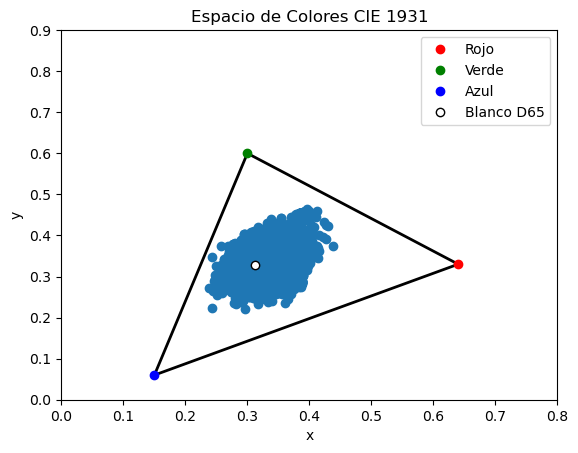

In [13]:
import matplotlib.patches as patches
from matplotlib.path import Path

# Define las coordenadas de cromaticidad de los colores primarios y el blanco
x_red, y_red = 0.64, 0.33
x_green, y_green = 0.30, 0.60
x_blue, y_blue = 0.15, 0.06
x_white, y_white = 0.3127, 0.3290  # Blanco D65

# Define el diagrama de cromaticidad
chromaticity_diagram = Path([
    (x_red, y_red),
    (x_green, y_green),
    (x_blue, y_blue),
    (x_red, y_red)
])

# Crea un gráfico
fig, ax = plt.subplots()

# Añade el diagrama de cromaticidad al gráfico
patch = patches.PathPatch(chromaticity_diagram, facecolor='none', lw=2)
ax.add_patch(patch)

# Añade los puntos de los colores primarios y el blanco
ax.plot(x_red, y_red, 'ro', label='Rojo')
ax.plot(x_green, y_green, 'go', label='Verde')
ax.plot(x_blue, y_blue, 'bo', label='Azul')
ax.plot(x_white, y_white, 'wo', markeredgecolor='k', label='Blanco D65')

# Configura los límites y etiquetas del gráfico
ax.set_xlim(0, 0.8)
ax.set_ylim(0, 0.9)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Espacio de Colores CIE 1931')
ax.legend()

ax.scatter(x = df['x'], y = df['y'])
# Muestra el gráfico
plt.show()


C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # n

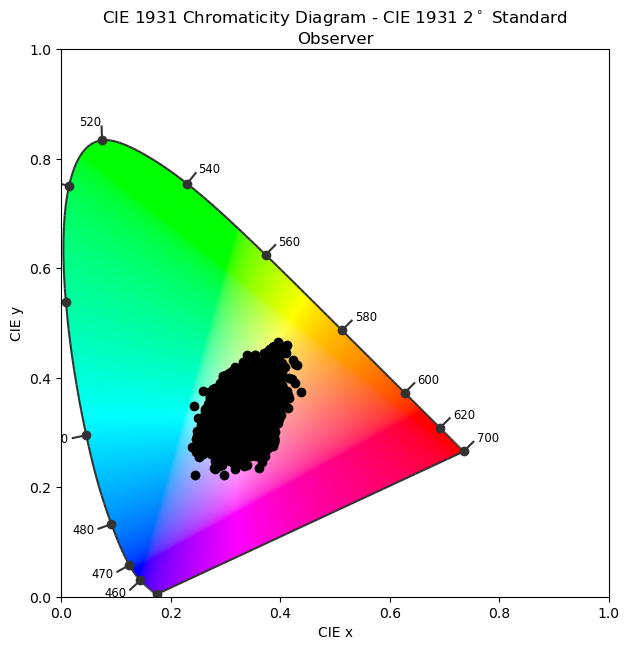

In [14]:
import colour

# Define your scatter plot points (CIE xy coordinates)
x = df['x']
y = df['y']

# Plot the CIE 1931 Chromaticity Diagram
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

# Scatter plot of your points
plt.scatter(x, y, c='black')
# Show the plot
plt.show()

## Data Split en test y training

In [15]:
x_train, x_test, y_train, y_test = train_test_split(df_3.drop(['R', 'DEE', 'Remb'], axis = 1), df_3[['R', 'DEE', 'Remb']], test_size = 0.33, random_state = 17)

In [16]:
# R
df_R = utils.shuffle(df_R, random_state = 10)
R_x_train, R_x_test, R_y_train, R_y_test = train_test_split(df_R.drop(['R'],axis=1),df_R['R'],test_size=0.33,random_state=17)
R_x_train.shape,R_x_test.shape

((16504, 3), (8129, 3))

In [17]:
# DEE
df_DEE = utils.shuffle(df_DEE, random_state = 20)
DEE_x_train, DEE_x_test, DEE_y_train, DEE_y_test = train_test_split(df_DEE.drop(['DEE'],axis=1),df_DEE['DEE'],test_size=0.33,random_state=17)
DEE_x_train.shape,DEE_x_test.shape

((16504, 3), (8129, 3))

In [18]:
# Remb
df_Remb = utils.shuffle(df_Remb, random_state = 30)
Remb_x_train, Remb_x_test, Remb_y_train, Remb_y_test = train_test_split(df_Remb.drop(['Remb'],axis=1),df_Remb['Remb'],test_size=0.33,random_state=17)
Remb_x_train.shape,Remb_x_test.shape

((16504, 3), (8129, 3))

## Obtencion de modelos para la prediccion de la variable R




### **Mean Squared Error**
$MSE = \frac{1}{n} \sum_{i=1}^{n} ({y}_{i}-\hat{y}_{i})^{2}$  
**Rango**: 0 ≤ MSE < ∞  
**Ideal**: 0   
### **Root Mean Squared Error**
$RMSE = \sqrt{MSE}$  
**Rango**: 0 ≤ RMSE < ∞  
**Ideal**: 0   
### **Mean Absolute Error**
$MAE = \frac{1}{n} \sum_{i=1}^{n} |{y}_{i}-{\hat{y}}_{i}|$  
**Rango**: 0 ≤ MAE <∞  
**Ideal**: 0 
### **R-square(Coefficient of Determination)**
$R^{2} = 1-\frac{\sum_{i=1}^{n}(y_{i}-\hat{y}_{i})^{2}}{\sum_{i=1}^{n}(y_{i}-\bar{y}_{i})^{2}}$  
**Rango**: −∞ ≤ $R^{2}$ ≤1  
**Ideal**: 1 
### **Explained Variance Score**
$EVS = 1 - \frac{Var\{y_{i}-\hat{y}_{i}\}}{Var\{y_{i}\}}$  
**Rango**: −∞ ≤ EVS ≤ 1  
**Ideal**: 1 

## Obtencion del modelo para el parametro R
## TensorFlow

In [ ]:
# Crear el modelo
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(3,), activation='relu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(16, activation='softsign', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(8, activation='relu', kernel_initializer='he_normal'),
    keras.layers.Dense(1)
])

# Implementación del learning rate decay
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.05,  
    decay_steps=30,  
    alpha=0.01,  
    name='LearningRateDecay'
)

optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

# Compilación del modelo
model.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(), ]
)


In [ ]:
# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

# Entrenar el modelo y guardar el historial
history = model.fit(Remb_x_train, Remb_y_train, epochs=1000, validation_data=(Remb_x_test, Remb_y_test),)

In [ ]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
model.evaluate(R_x_test, R_y_test)

In [ ]:
loss, mae_value, r2_value = model.evaluate(R_x_test, R_y_test, verbose=0)
print(f"MAE: {mae_value:.4f}")
print(f"R2 Score: {r2_value:.4f}")

## Propuesta dos

In [ ]:
activation = ['relu', 'softplus', 'softsign', 'swish', 'tanh']
estimator_optimizer : ['SGD', 'RMSprop', 'Adam', 'Adadelta']
mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
dropout = [0.0, 0.1, 0.2, 0.3],
regularizer = [None, keras.regularizers.l1(0.01), keras.regularizers.l2(0.01)]


In [ ]:
# !pip install optuna

In [ ]:
import optuna

# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation, optimizer, init_mode, dropout_rate, regularizer_type):
    
    if regularizer_type == "l1":
        regularizer = keras.regularizers.l1(0.01)
    elif regularizer_type == "l2":
        regularizer = keras.regularizers.l2(0.01)
    else:
        regularizer = None
        
    model = keras.Sequential()
    model.add(keras.layers.Dense(64, input_shape=(R_x_train.shape[1],), activation=activation, 
                                 kernel_initializer=init_mode, kernel_regularizer=regularizer))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(32, activation=activation, kernel_initializer=init_mode))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(8, activation=activation, kernel_initializer=init_mode))
    model.add(keras.layers.Dense(3))
    
    model.compile(optimizer=optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.R2Score()])
    return model

# Función objetivo para Optuna
def objective(trial):

    activation = trial.suggest_categorical('activation', ['relu', 'softplus', 'softsign', 'swish', 'tanh'])
    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'RMSprop', 'Adam', 'Adadelta'])
    init_mode = trial.suggest_categorical('init_mode', ['uniform', 'lecun_uniform', 'normal', 'zero', 
                                                        'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.3, step=0.1)
    regularizer_type = trial.suggest_categorical('regularizer_type', [None, "l1", "l2"])

    
    model = create_model(activation, optimizer, init_mode, dropout_rate, regularizer_type)
    history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=0, validation_split=0.2)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['mean_absolute_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros:", study.best_params)


In [55]:
# Define el modelo dentro de una función que tomará los hiperparámetros como argumentos
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, 
                 init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6):

    model = keras.Sequential([
        keras.layers.Dense(512, input_shape=(R_x_train.shape[1],), activation=activation_1, kernel_initializer=init_mode_1),
        keras.layers.Dense(256, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(128, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(64, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(32, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(16, activation=activation_6, kernel_initializer=init_mode_6),
        keras.layers.Dense(3)
    ])
    model.compile(optimizer='RMSprop',
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(),])
    return model

# Función objetivo para Optuna
def objective(trial):
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
    
    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
              
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6,
                 init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6)
    history = model.fit(x_train, y_train, epochs=10, validation_split=0.2, verbose=0)
    
    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['mean_absolute_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

print("Mejores hiperparámetros:", study.best_params)


[I 2023-10-17 20:16:09,112] A new study created in memory with name: no-name-5d35945a-bf36-4898-bebb-8210474a21bc
[I 2023-10-17 20:16:25,807] Trial 0 finished with value: 0.2118588089942932 and parameters: {'activation_1': 'softmax', 'activation_2': 'exponential', 'activation_3': 'hard_sigmoid', 'activation_4': 'softplus', 'activation_5': 'hard_sigmoid', 'activation_6': 'softsign', 'init_mode_1': 'glorot_uniform', 'init_mode_2': 'zero', 'init_mode_3': 'he_uniform', 'init_mode_4': 'he_uniform', 'init_mode_5': 'lecun_uniform', 'init_mode_6': 'lecun_uniform'}. Best is trial 0 with value: 0.2118588089942932.
[I 2023-10-17 20:16:41,104] Trial 1 finished with value: 0.21205845475196838 and parameters: {'activation_1': 'swish', 'activation_2': 'hard_sigmoid', 'activation_3': 'softsign', 'activation_4': 'softplus', 'activation_5': 'sigmoid', 'activation_6': 'tanh', 'init_mode_1': 'zero', 'init_mode_2': 'glorot_uniform', 'init_mode_3': 'he_uniform', 'init_mode_4': 'uniform', 'init_mode_5': 'nor

[I 2023-10-17 20:21:09,883] Trial 18 finished with value: 0.17805880308151245 and parameters: {'activation_1': 'softsign', 'activation_2': 'selu', 'activation_3': 'elu', 'activation_4': 'elu', 'activation_5': 'softplus', 'activation_6': 'softplus', 'init_mode_1': 'he_normal', 'init_mode_2': 'he_uniform', 'init_mode_3': 'lecun_uniform', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:21:26,094] Trial 19 finished with value: 0.21174053847789764 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'swish', 'activation_4': 'selu', 'activation_5': 'swish', 'activation_6': 'selu', 'init_mode_1': 'zero', 'init_mode_2': 'glorot_normal', 'init_mode_3': 'zero', 'init_mode_4': 'lecun_uniform', 'init_mode_5': 'uniform', 'init_mode_6': 'lecun_uniform'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:21:41,801] Trial 20 finished with value: 0.204246699810

[I 2023-10-17 20:25:53,555] Trial 36 finished with value: 0.2124093472957611 and parameters: {'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_3': 'softmax', 'activation_4': 'relu', 'activation_5': 'hard_sigmoid', 'activation_6': 'linear', 'init_mode_1': 'glorot_uniform', 'init_mode_2': 'he_uniform', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'he_uniform', 'init_mode_5': 'glorot_normal', 'init_mode_6': 'normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:26:09,817] Trial 37 finished with value: 0.1806577891111374 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'swish', 'activation_4': 'elu', 'activation_5': 'swish', 'activation_6': 'softsign', 'init_mode_1': 'normal', 'init_mode_2': 'normal', 'init_mode_3': 'he_uniform', 'init_mode_4': 'glorot_normal', 'init_mode_5': 'he_uniform', 'init_mode_6': 'he_normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:26:26,123] Trial 38 finished with value

[I 2023-10-17 20:30:39,355] Trial 54 finished with value: 0.18167831003665924 and parameters: {'activation_1': 'softsign', 'activation_2': 'selu', 'activation_3': 'exponential', 'activation_4': 'softsign', 'activation_5': 'softsign', 'activation_6': 'hard_sigmoid', 'init_mode_1': 'he_normal', 'init_mode_2': 'he_normal', 'init_mode_3': 'zero', 'init_mode_4': 'normal', 'init_mode_5': 'glorot_uniform', 'init_mode_6': 'normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:30:55,425] Trial 55 finished with value: 0.1769537478685379 and parameters: {'activation_1': 'softsign', 'activation_2': 'softplus', 'activation_3': 'elu', 'activation_4': 'swish', 'activation_5': 'swish', 'activation_6': 'swish', 'init_mode_1': 'he_normal', 'init_mode_2': 'he_uniform', 'init_mode_3': 'lecun_uniform', 'init_mode_4': 'normal', 'init_mode_5': 'lecun_uniform', 'init_mode_6': 'normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:31:11,023] Trial 56 finished with va

[I 2023-10-17 20:35:17,874] Trial 72 finished with value: 0.17377983033657074 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'elu', 'activation_4': 'tanh', 'activation_5': 'tanh', 'activation_6': 'softsign', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_uniform', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'he_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'glorot_normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:35:33,292] Trial 73 finished with value: 0.1739492267370224 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'elu', 'activation_4': 'tanh', 'activation_5': 'tanh', 'activation_6': 'softsign', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_uniform', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'he_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'glorot_normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:35:48,535] Trial 74 finished with value: 0

[I 2023-10-17 20:39:57,497] Trial 90 finished with value: 0.1822182536125183 and parameters: {'activation_1': 'softsign', 'activation_2': 'sigmoid', 'activation_3': 'tanh', 'activation_4': 'softplus', 'activation_5': 'tanh', 'activation_6': 'swish', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_uniform', 'init_mode_3': 'lecun_uniform', 'init_mode_4': 'glorot_uniform', 'init_mode_5': 'he_uniform', 'init_mode_6': 'normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:40:13,355] Trial 91 finished with value: 0.17306110262870789 and parameters: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'elu', 'activation_4': 'tanh', 'activation_5': 'tanh', 'activation_6': 'softsign', 'init_mode_1': 'he_uniform', 'init_mode_2': 'glorot_uniform', 'init_mode_3': 'glorot_uniform', 'init_mode_4': 'he_uniform', 'init_mode_5': 'normal', 'init_mode_6': 'glorot_normal'}. Best is trial 14 with value: 0.1719057559967041.
[I 2023-10-17 20:40:29,254] Trial 92 finished wi

Mejores hiperparámetros: {'activation_1': 'elu', 'activation_2': 'elu', 'activation_3': 'elu', 'activation_4': 'tanh', 'activation_5': 'swish', 'activation_6': 'swish', 'init_mode_1': 'he_normal', 'init_mode_2': 'he_uniform', 'init_mode_3': 'lecun_uniform', 'init_mode_4': 'normal', 'init_mode_5': 'he_uniform', 'init_mode_6': 'normal'}


# Utilizando los mejores hiperparametros

In [66]:
# Crear el modelo
model = keras.Sequential([
    keras.layers.Dense(512, input_shape=(R_x_train.shape[1],), activation='elu', kernel_initializer='he_normal',),
    keras.layers.Dense(256, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(128, activation='elu', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(64, activation='tanh', kernel_initializer='normal'),
    keras.layers.Dense(32, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(15, activation='swish', kernel_initializer='normal'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(), ]
)


In [67]:
# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=100)

# Entrenar el modelo y guardar el historial
history = model.fit(x_train, y_train, epochs=500, validation_data=(x_test, y_test),)

Epoch 1/500
516/516 [==============================] - 5s 7ms/step - loss: 0.0624 - mean_absolute_error: 0.2053 - val_loss: 0.0563 - val_mean_absolute_error: 0.1917
Epoch 2/500
516/516 [==============================] - 4s 8ms/step - loss: 0.0556 - mean_absolute_error: 0.1926 - val_loss: 0.0529 - val_mean_absolute_error: 0.1855
Epoch 3/500
516/516 [==============================] - 4s 7ms/step - loss: 0.0531 - mean_absolute_error: 0.1868 - val_loss: 0.0510 - val_mean_absolute_error: 0.1867
Epoch 4/500
516/516 [==============================] - 4s 7ms/step - loss: 0.0513 - mean_absolute_error: 0.1822 - val_loss: 0.0520 - val_mean_absolute_error: 0.1840
Epoch 5/500
516/516 [==============================] - 4s 8ms/step - loss: 0.0505 - mean_absolute_error: 0.1795 - val_loss: 0.0476 - val_mean_absolute_error: 0.1731
Epoch 6/500
516/516 [==============================] - 3s 7ms/step - loss: 0.0494 - mean_absolute_error: 0.1764 - val_loss: 0.0484 - val_mean_absolute_error: 0.1743
Epoch 7/50

516/516 [==============================] - 5s 9ms/step - loss: 0.0433 - mean_absolute_error: 0.1582 - val_loss: 0.0431 - val_mean_absolute_error: 0.1582
Epoch 100/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0433 - mean_absolute_error: 0.1586 - val_loss: 0.0429 - val_mean_absolute_error: 0.1559
Epoch 101/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0432 - mean_absolute_error: 0.1581 - val_loss: 0.0437 - val_mean_absolute_error: 0.1601
Epoch 102/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0432 - mean_absolute_error: 0.1582 - val_loss: 0.0430 - val_mean_absolute_error: 0.1561
Epoch 103/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0432 - mean_absolute_error: 0.1582 - val_loss: 0.0428 - val_mean_absolute_error: 0.1566
Epoch 104/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0430 - mean_absolute_error: 0.1579 - val_loss: 0.0431 - val_mean_absolute_error: 0.1554
Epoch 105/50

516/516 [==============================] - 6s 13ms/step - loss: 0.0428 - mean_absolute_error: 0.1570 - val_loss: 0.0468 - val_mean_absolute_error: 0.1667
Epoch 149/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0428 - mean_absolute_error: 0.1571 - val_loss: 0.0433 - val_mean_absolute_error: 0.1549
Epoch 150/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0427 - mean_absolute_error: 0.1569 - val_loss: 0.0428 - val_mean_absolute_error: 0.1582
Epoch 151/500
516/516 [==============================] - 4s 9ms/step - loss: 0.0428 - mean_absolute_error: 0.1571 - val_loss: 0.0424 - val_mean_absolute_error: 0.1565
Epoch 152/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0428 - mean_absolute_error: 0.1571 - val_loss: 0.0426 - val_mean_absolute_error: 0.1566
Epoch 153/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0427 - mean_absolute_error: 0.1569 - val_loss: 0.0427 - val_mean_absolute_error: 0.1548
Epoch 154/

Epoch 197/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0424 - mean_absolute_error: 0.1562 - val_loss: 0.0433 - val_mean_absolute_error: 0.1576
Epoch 198/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0425 - mean_absolute_error: 0.1561 - val_loss: 0.0443 - val_mean_absolute_error: 0.1602
Epoch 199/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0426 - mean_absolute_error: 0.1564 - val_loss: 0.0424 - val_mean_absolute_error: 0.1557
Epoch 200/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0426 - mean_absolute_error: 0.1565 - val_loss: 0.0429 - val_mean_absolute_error: 0.1574
Epoch 201/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0426 - mean_absolute_error: 0.1565 - val_loss: 0.0427 - val_mean_absolute_error: 0.1569
Epoch 202/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0427 - mean_absolute_error: 0.1566 - val_loss: 0.0440 - val_mean_absolute_error: 

Epoch 246/500
516/516 [==============================] - 5s 11ms/step - loss: 0.0423 - mean_absolute_error: 0.1558 - val_loss: 0.0423 - val_mean_absolute_error: 0.1544
Epoch 247/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0425 - mean_absolute_error: 0.1561 - val_loss: 0.0424 - val_mean_absolute_error: 0.1564
Epoch 248/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0426 - mean_absolute_error: 0.1567 - val_loss: 0.0425 - val_mean_absolute_error: 0.1562
Epoch 249/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0426 - mean_absolute_error: 0.1564 - val_loss: 0.0428 - val_mean_absolute_error: 0.1592
Epoch 250/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0425 - mean_absolute_error: 0.1566 - val_loss: 0.0446 - val_mean_absolute_error: 0.1621
Epoch 251/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0424 - mean_absolute_error: 0.1561 - val_loss: 0.0425 - val_mean_absolute_error: 

Epoch 295/500
516/516 [==============================] - 4s 8ms/step - loss: 0.0422 - mean_absolute_error: 0.1554 - val_loss: 0.0424 - val_mean_absolute_error: 0.1547
Epoch 296/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0424 - mean_absolute_error: 0.1559 - val_loss: 0.0428 - val_mean_absolute_error: 0.1567
Epoch 297/500
516/516 [==============================] - 8s 15ms/step - loss: 0.0423 - mean_absolute_error: 0.1556 - val_loss: 0.0431 - val_mean_absolute_error: 0.1566
Epoch 298/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0423 - mean_absolute_error: 0.1557 - val_loss: 0.0432 - val_mean_absolute_error: 0.1534
Epoch 299/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0422 - mean_absolute_error: 0.1553 - val_loss: 0.0442 - val_mean_absolute_error: 0.1618
Epoch 300/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0424 - mean_absolute_error: 0.1558 - val_loss: 0.0425 - val_mean_absolute_error: 

Epoch 344/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0422 - mean_absolute_error: 0.1554 - val_loss: 0.0430 - val_mean_absolute_error: 0.1563
Epoch 345/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0421 - mean_absolute_error: 0.1549 - val_loss: 0.0435 - val_mean_absolute_error: 0.1586
Epoch 346/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0422 - mean_absolute_error: 0.1553 - val_loss: 0.0428 - val_mean_absolute_error: 0.1559
Epoch 347/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0423 - mean_absolute_error: 0.1555 - val_loss: 0.0433 - val_mean_absolute_error: 0.1585
Epoch 348/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0422 - mean_absolute_error: 0.1549 - val_loss: 0.0428 - val_mean_absolute_error: 0.1567
Epoch 349/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0422 - mean_absolute_error: 0.1553 - val_loss: 0.0423 - val_mean_absolute_error:

Epoch 393/500
516/516 [==============================] - 5s 10ms/step - loss: 0.0422 - mean_absolute_error: 0.1553 - val_loss: 0.0441 - val_mean_absolute_error: 0.1598
Epoch 394/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0422 - mean_absolute_error: 0.1555 - val_loss: 0.0424 - val_mean_absolute_error: 0.1547
Epoch 395/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0422 - mean_absolute_error: 0.1556 - val_loss: 0.0426 - val_mean_absolute_error: 0.1562
Epoch 396/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0422 - mean_absolute_error: 0.1552 - val_loss: 0.0425 - val_mean_absolute_error: 0.1553
Epoch 397/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0422 - mean_absolute_error: 0.1554 - val_loss: 0.0430 - val_mean_absolute_error: 0.1564
Epoch 398/500
516/516 [==============================] - 5s 9ms/step - loss: 0.0422 - mean_absolute_error: 0.1550 - val_loss: 0.0425 - val_mean_absolute_error: 0.1

Epoch 442/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0424 - mean_absolute_error: 0.1558 - val_loss: 0.0426 - val_mean_absolute_error: 0.1557
Epoch 443/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0424 - mean_absolute_error: 0.1560 - val_loss: 0.0438 - val_mean_absolute_error: 0.1577
Epoch 444/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0423 - mean_absolute_error: 0.1556 - val_loss: 0.0426 - val_mean_absolute_error: 0.1560
Epoch 445/500
516/516 [==============================] - 6s 11ms/step - loss: 0.0422 - mean_absolute_error: 0.1554 - val_loss: 0.0432 - val_mean_absolute_error: 0.1566
Epoch 446/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0422 - mean_absolute_error: 0.1553 - val_loss: 0.0428 - val_mean_absolute_error: 0.1568
Epoch 447/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0423 - mean_absolute_error: 0.1555 - val_loss: 0.0429 - val_mean_absolute_error:

Epoch 491/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0420 - mean_absolute_error: 0.1550 - val_loss: 0.0428 - val_mean_absolute_error: 0.1529
Epoch 492/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0423 - mean_absolute_error: 0.1556 - val_loss: 0.0425 - val_mean_absolute_error: 0.1559
Epoch 493/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0425 - mean_absolute_error: 0.1559 - val_loss: 0.0428 - val_mean_absolute_error: 0.1576
Epoch 494/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0423 - mean_absolute_error: 0.1558 - val_loss: 0.0451 - val_mean_absolute_error: 0.1617
Epoch 495/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0425 - mean_absolute_error: 0.1562 - val_loss: 0.0431 - val_mean_absolute_error: 0.1566
Epoch 496/500
516/516 [==============================] - 6s 12ms/step - loss: 0.0421 - mean_absolute_error: 0.1551 - val_loss: 0.0425 - val_mean_absolute_error:

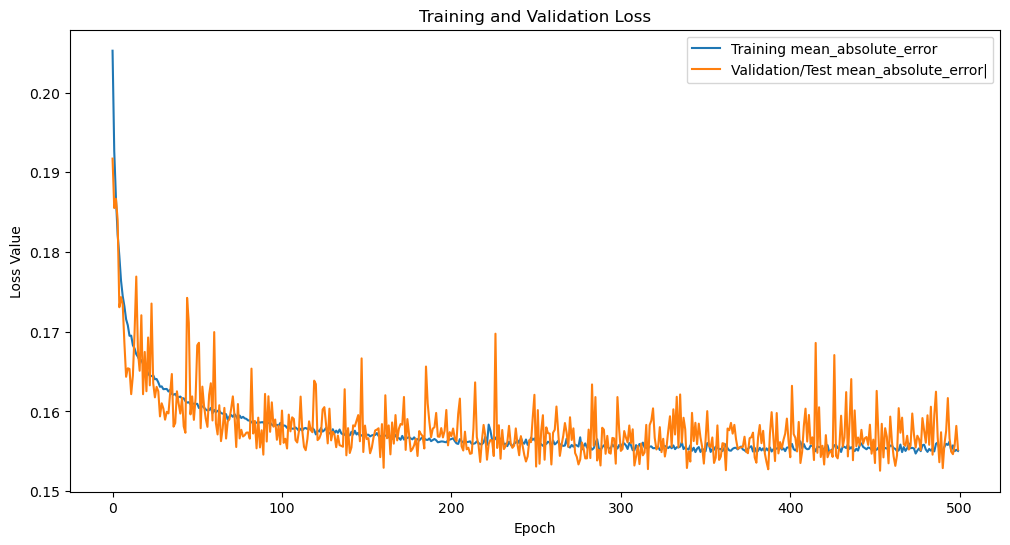

In [68]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_error'], label='Training mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [69]:
model.evaluate(x_test, y_test)

255/255 [==============================] - 2s 6ms/step - loss: 0.0428 - mean_absolute_error: 0.1552


[0.042796261608600616, 0.15522275865077972]

In [ ]:
#  Trial 0 finished with value: 0.22715312242507935 and parameters: {'activation': 'swish', 'optimizer': 'RMSprop', 'init_mode': 'glorot_uniform', 'dropout_rate': 0.1, 'regularizer_type': 'l1'}. Best is trial 0 with value: 0.22715312242507935.


## 2.0

In [ ]:
# Crear el modelo
model = keras.Sequential([
    keras.layers.Dense(64, input_shape=(R_x_train.shape[1],),activation='relu'),
    keras.layers.Dense(32, activation='softplus'),
    keras.layers.Dense(16, activation='softsign'),
    keras.layers.Dense(8, activation='swish'),
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1)
])

# Learning rate decay
tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=0.01,
    decay_steps=50,
    alpha=0.1,
    name='Learning rate decay'
)
callback = tf.keras.callbacks.EarlyStopping(monitor='r2_score', patience=50)
# Compilar el modelo
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=keras.losses.MeanAbsoluteError(),
    metrics=[keras.metrics.R2Score()]
)


In [ ]:
# Entrenar el modelo y guardar el historial
history = model.fit(R_x_train, R_y_train, epochs=2000, validation_data=(R_x_test, R_y_test),)

In [ ]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation/Test Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

In [ ]:
model.evaluate(R_x_test, R_y_test)

In [ ]:
mae_value, r2_value = model.evaluate(R_x_test, R_y_test, verbose=0)
print(f"MAE: {mae_value:.4f}")
print(f"R2 Score: {r2_value:.4f}")

## TensorBoard

In [ ]:
# def create_model():
# # Crear el modelo
#     return keras.Sequential([
#         keras.layers.Dense(64, input_shape=(R_x_train.shape[1],),activation='relu'),
#         keras.layers.Dense(32, activation='relu'),
#         keras.layers.Dense(8, activation='swish'),
#         keras.layers.Dense(1)
#     ])


# model = create_model()
# # Compilar el modelo
# model.compile(
#     optimizer=keras.optimizers.Adam(learning_rate=0.01),
#     loss=keras.losses.MeanSquaredError(),
#     metrics=[keras.metrics.MeanAbsoluteError()]
# )
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# model.fit(x=R_x_train, 
#           y=R_y_train, 
#           epochs=5, 
#           validation_data=(R_x_test, R_y_test), 
#           callbacks=[tensorboard_callback])

In [ ]:
# !taskkill /PID 11076 /F
# %tensorboard --logdir=logs/fit --port=6006

### Obtencion del modelo para el parametro DEE

### Obtencion del modelo para el parametro Remb